In [40]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from model import get_model
import dataset
from torch.utils.data import DataLoader
from torchvision import transforms


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

In [2]:
best_model_epoch = 105
last_model_epoch = 200

best_model_dict = torch.load(f"./checkpoints/vehicle_damage_convnext_{best_model_epoch}.pth")
last_model_dict = torch.load(f"./checkpoints/vehicle_damage_convnext_{last_model_epoch}.pth")

In [3]:
epochs = last_model_dict['epoch']
loss_history = last_model_dict['loss_history']
training_accuracy_history = last_model_dict['training_accuracy_history']
val_accuracy_history = last_model_dict['val_accuracy_history']

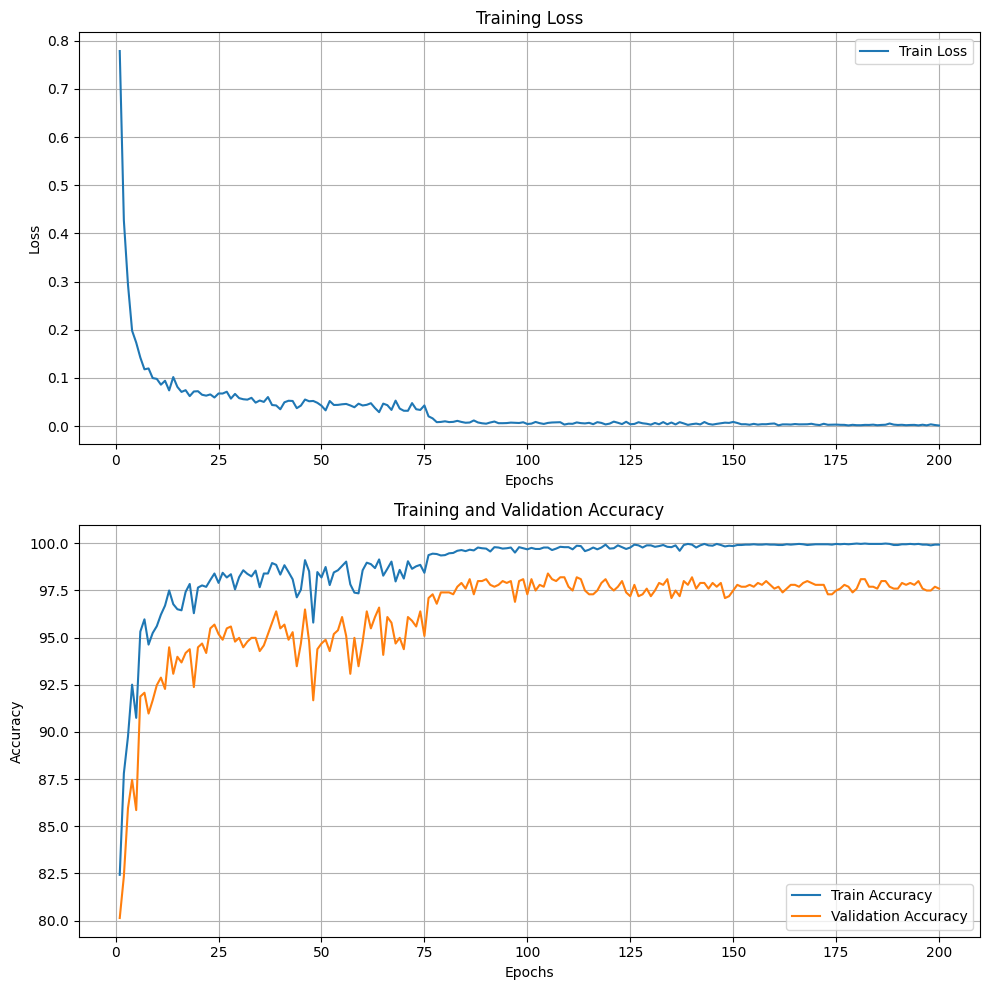

In [4]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

x = np.arange(1, 201)
# Plot train loss
ax1.plot(x, loss_history, label='Train Loss')
ax1.set_title('Training Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot train and validation accuracy
ax2.plot(x, training_accuracy_history, label='Train Accuracy')
ax2.plot(x, val_accuracy_history, label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [54]:
best_model = get_model().to(device)
best_model.load_state_dict(best_model_dict['model'])

<All keys matched successfully>

In [56]:
image_dims = (224, 224)

transform = transforms.Compose([
    transforms.Resize(image_dims),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4772, 0.4597, 0.4612], std=[0.2997, 0.2808, 0.2837])
])

_, _, test_dataset = dataset.get_datasets(transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

In [142]:
# function to calcualte accuracy of the model
def calculate_accuracy(model, dataloader):
    model.eval()
    correct = 0
    confusion_matrix = np.zeros([6, 6], int)

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()

            for i, l in enumerate(labels):
                confusion_matrix[l.item(), pred[i].item()] += 1

    accuracy = (correct / len(dataloader.dataset)) * 100

    return accuracy, confusion_matrix


In [143]:
test_accuracy, confusion_matrix = calculate_accuracy(best_model, test_loader)

In [127]:
print("Best model test accuracy: {:.3f}%".format(test_accuracy))

Best model test accuracy: 97.328%


In [147]:
# make precentage for each row
confusion_matrix_precentage = confusion_matrix/ confusion_matrix.astype(np.float64).sum(axis=1)

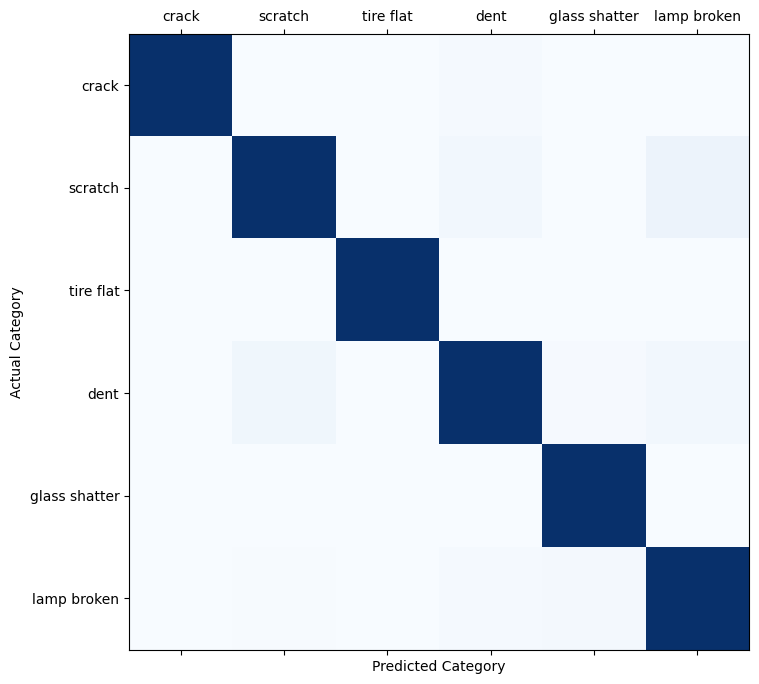

In [150]:
classes = [dataset.label_to_cls[label] for label in dataset.label_to_cls.keys()]

# plot confusion matrix
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.matshow(confusion_matrix_precentage, aspect='auto', vmin=0, vmax=0.6, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(6), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(6), classes)
plt.show()